Para el siguiente análisis de datos usaré la popular libreria tidyverse para usar las funcionalidades de ggplot2 y dyplr. Adicionalmente se caragra la libreria sf con el fin de hacer más ameno la carga de mapas que serán de mucha utilidad a la hora de ver los datos. 

In [ ]:
setwd("/home/creambbq/code/bikes/archivos")
library(tidyverse)
library(sf)
library(ggthemes)
load("cleanData.RData")
bairesMap <- st_read("http://cdn.buenosaires.gob.ar/datosabiertos/datasets/barrios/barrios.geojson",
                     stringsAsFactors = FALSE)
bairesMap <- bairesMap %>% mutate(km2 = as.numeric(AREA)/1000000)
stations <- ecoBiciData %>% group_by(nombre_estacion_origen,lat_estacion_origen,long_estacion_origen) %>% summarise() %>%  ungroup()

Lo primero será ver como están distribuidas las diferentes estaciones del servicio dentro de la ciudad. 

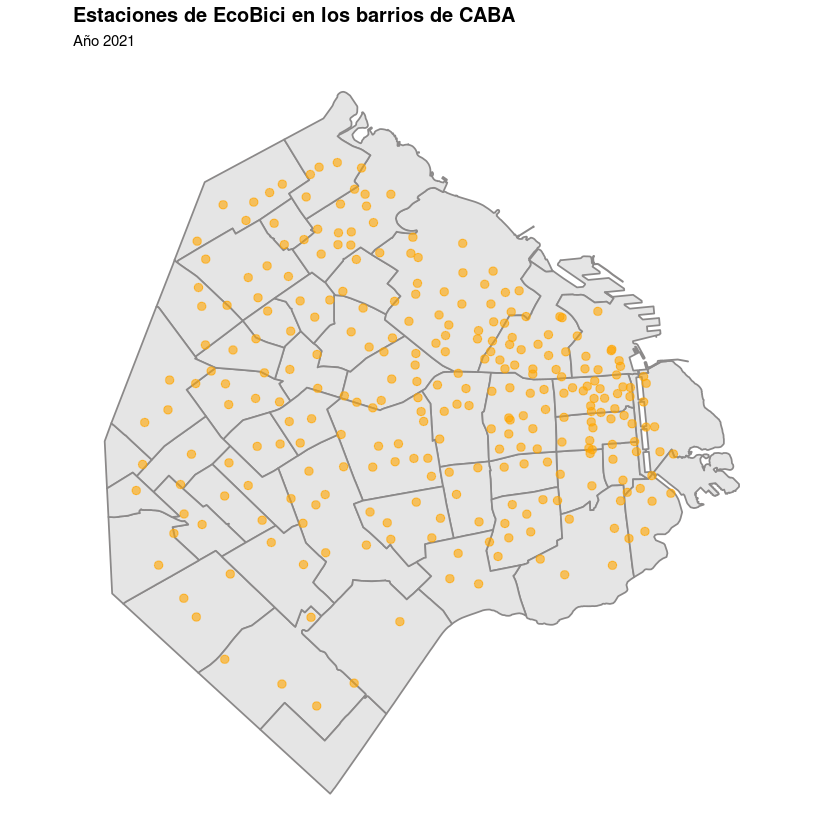

In [2]:
ggplot() + 
  geom_sf(data = bairesMap, color = "snow4") +
  geom_point(data = stations, aes(x = long_estacion_origen, y = lat_estacion_origen),
             color = "orange", size = 2, alpha = 0.6) +
  labs(title = "Estaciones de EcoBici en los barrios de CABA", 
       subtitle = "Año 2021") +
  theme_map() +
  theme(plot.title = element_text(size = 12, face = "bold"))